In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [22]:
def importImage(path):
    images = []
    folder_path = path
    file_names = os.listdir(folder_path)
    i = 0
    for file_name in file_names:
        i+=1
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        images.append(image)
        if i == 10 : break
    return images

In [23]:
imageRed = importImage("traffic_light_data/train/red")
imageYellow = importImage("traffic_light_data/train/yellow")
imageGreen = importImage("traffic_light_data/train/green")

In [24]:
def displayGrayImage(images):
    plt.figure(figsize=(20,20))
    for i in range(len(images)):
        plt.subplot(10,10,i+1)
        gray_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        plt.imshow(gray_image, cmap='gray')

In [25]:
def displayColorImage(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(10, 10, i+1)
        bgr_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(bgr_image)
    plt.show()


In [26]:
def resizeImage(images):
    images_resize = []
    for image in images:
        image_resize = cv2.resize(image,(200,400))
        images_resize.append(image_resize)
    return images_resize

In [27]:
imageRed_resize = resizeImage(imageRed)
imageYellow_resize = resizeImage(imageYellow)
imageGreen_resize = resizeImage(imageGreen)

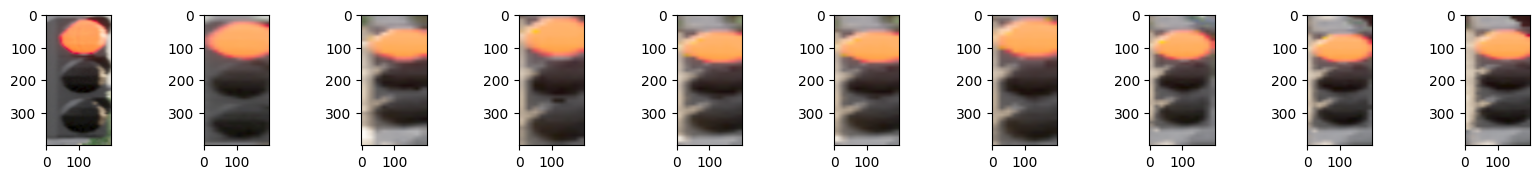

In [28]:
displayColorImage(imageRed_resize)

In [29]:
def noiseRemoval(images):
    images_noise = []
    for image in images:
        image_noise = cv2.GaussianBlur(image, (5, 5), 0)
        images_noise.append(image_noise)
    return images_noise

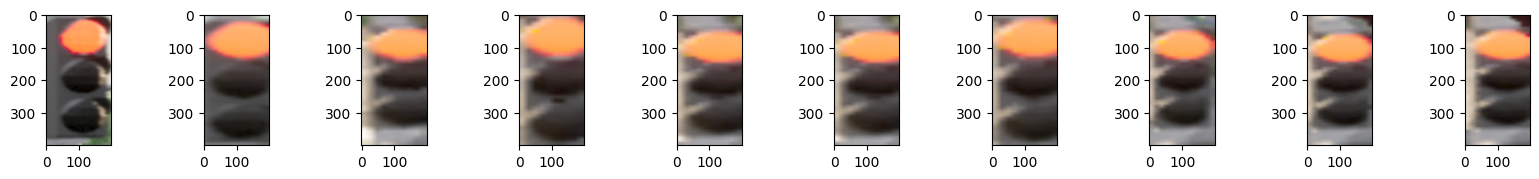

In [30]:
blurRed = noiseRemoval(imageRed_resize)
displayColorImage(blurRed)

In [31]:
def contrastEnhancement(images):
    images_contrast = []
    for image in images:
        image_contrast = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
        images_contrast.append(image_contrast)
    return images_contrast

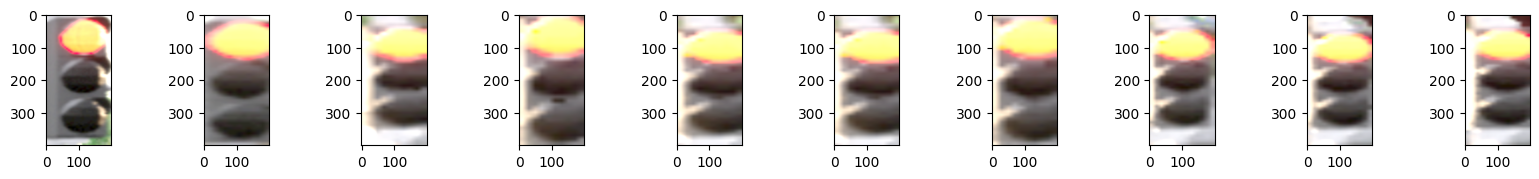

In [32]:
contrastRed = contrastEnhancement(blurRed)
displayColorImage(contrastRed)

In [33]:
def normalize(images):
    images_normalize = []
    for image in images:
        image_normalize = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        images_normalize.append(image_normalize)
    return images_normalize

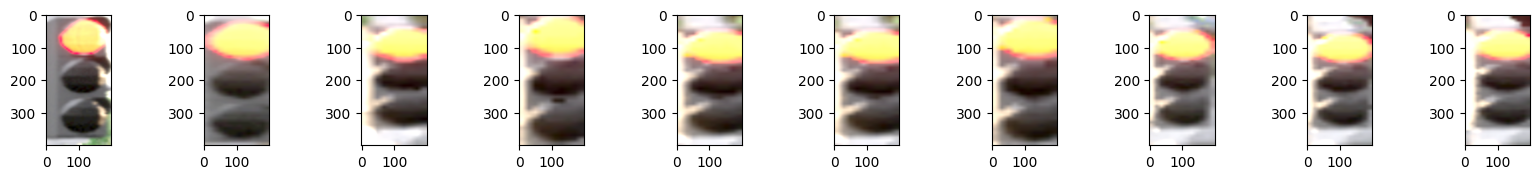

In [34]:
normalizeRed = normalize(contrastRed)
displayColorImage(normalizeRed)

In [35]:
def edgeSegmentation(images):
    images_segmentasi = []
    for image in images:
        image_segmentasi = cv2.Canny(image, 50, 0)
        image_segmentasi = cv2.dilate(image_segmentasi, np.ones((3, 3)), iterations=1)
        # image_segmentasi = cv2.erode(image_segmentasi, np.ones((3, 3)), iterations=1)
        contours, _ = cv2.findContours(image_segmentasi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        image_segmentasi = cv2.drawContours(np.zeros_like(image_segmentasi), contours, -1, 255, thickness=1)
        images_segmentasi.append(image_segmentasi)
    return images_segmentasi


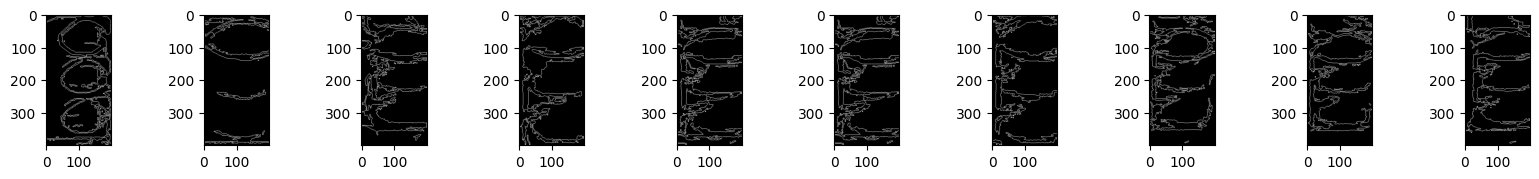

In [36]:
segmentasiRed = edgeSegmentation(normalizeRed)
displayColorImage(segmentasiRed)

In [37]:
def removeSmallArea(images):
    images_remove = []
    for image in images:
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) < 200:
                cv2.drawContours(image, [contour], -1, 0, thickness=-1)
        images_remove.append(image)
    return images_remove

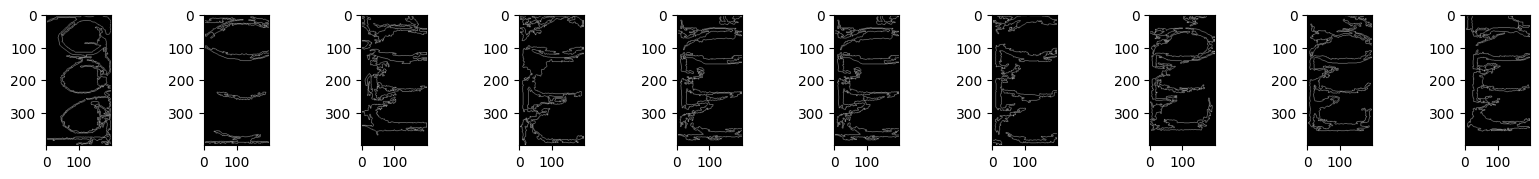

In [38]:
removeRed = removeSmallArea(segmentasiRed)
displayColorImage(removeRed)

In [39]:
def colourSegmentation(images):
    images_segmentasi = []
    for image in images:
        image_segmentasi = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_red = np.array([0, 100, 100])
        upper_red = np.array([10, 255, 255])
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([40, 255, 255])
        lower_green = np.array([50, 100, 100])
        upper_green = np.array([70, 255, 255])
        mask_red = cv2.inRange(image_segmentasi, lower_red, upper_red)
        mask_yellow = cv2.inRange(image_segmentasi, lower_yellow, upper_yellow)
        mask_green = cv2.inRange(image_segmentasi, lower_green, upper_green)
        mask = mask_red + mask_yellow + mask_green
        image_segmentasi = cv2.bitwise_and(image_segmentasi, image_segmentasi, mask=mask)
        images_segmentasi.append(image_segmentasi)
    return images_segmentasi

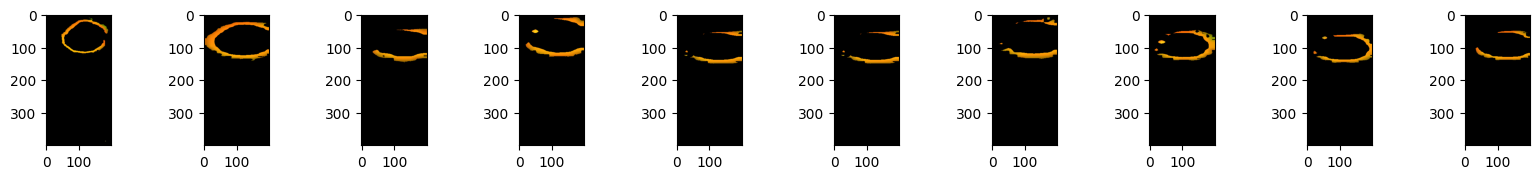

In [40]:
segmentasiWarnaRed = colourSegmentation(imageRed_resize)
displayColorImage(segmentasiWarnaRed)